In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gsw
import xarray as xr
from glob import glob
from scipy import interpolate

Dynamics

$$ \vec{v} = \vec{u} + \vec{v}_s$$

with

$\vec{v_s} = (1 - \beta) \vec{g} \tau_p$

$\beta = \frac{3 \rho_f}{2 \rho_p + \rho_f}$

$\tau_p = \frac{a^2}{3 \beta \nu}$

In [14]:
def sinking_velocity(β, τ):
    g=9.81
    v_s = (1 - β)*g*τ
    
    return v_s

def beta(ρ_f, ρ_p):
    _β = 3*ρ_f/(2*ρ_p + ρ_f)
    
    return _β

def tau_p(a, β, ν):
    _τ = a**2/(3*β*ν)
    
    return _τ
    

 - Polypropylene(PP): 850–920 kg/m3
 - Polyethylene (PE): 890–980 kg/m3
 - Polystyrene (PS): 1040 kg/m3 (excluding its foamed version)
 - Polyesters (PEST): 1100– 1400 kg/m3
 - Polyamide (PA): 1120–1150 kg/m3
 - Acrylic: of 1180 kg/m3 

### PP

In [15]:
100**3*1.38/1000

1380.0

In [16]:
ρ_sea = 1035
ρ_PE = 1380
ν = 1e-6

diametres = np.linspace(1, 100000, 1000)*1e-9

In [17]:
beta_PE = beta(ρ_sea, ρ_PE)

In [18]:
tau_PE = tau_p(diametres, beta_PE, ν)

In [19]:
vs_PE = sinking_velocity(beta_PE, tau_PE)

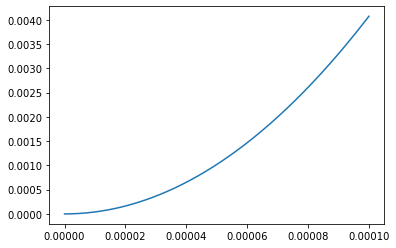

In [20]:
plt.plot(diametres, tau_PE)

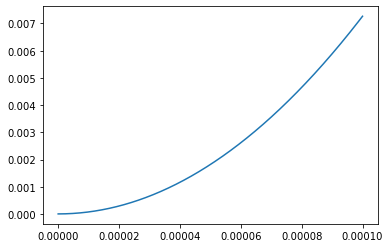

In [21]:
plt.plot(diametres, vs_PE)

## GSW density analysis

Basically the MOi dataset has data on Practical Salinity and Potential Temperature, but to compute the desnity of seawater with TEOS10, you need to have Absolute Salinity and Conservative Temperature. 

So the question is what happens if you don't convert the Practical Salinity and Potential Temperature, and direclty use the with the TEOS?

In [23]:
data_path = '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/'
mesh_mask = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/mesh_hgr.nc'

tfiles = sorted(glob(data_path + 'psy4v3r1-daily_T_2019-12*.nc'))    
sfiles = sorted(glob(data_path + 'psy4v3r1-daily_S_2019-12*.nc'))

In [24]:
tfiles

['/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-01.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-02.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-03.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-04.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-05.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-06.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-07.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-08.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-09.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-10.nc',
 '/storage/shared/oceanparcels/input_data/MOi/psy4v3r1/psy4v3r1-daily_T_2019-12-11.nc',
 '/storage/shared/oceanparcels/i

In [25]:
pot_temp = xr.load_dataset(tfiles[0])
PS = xr.load_dataset(sfiles[0])

In [26]:
depth = PS['deptht']

Pick the sampling position for this comparison

In [27]:
lon_sample = 6.287
lon_idx = 3520
lat_sample = -32.171
lat_idx = 1086

In [28]:
lat_min = np.abs(PS['nav_lat'][:,0] - lat_sample)
np.where(lat_min == np.min(lat_min))

(array([1086]),)

In [29]:
lon_min = np.abs(PS['nav_lon'][0,:] - lon_sample)
np.where(lon_min == np.min(lon_min))

(array([3520]),)

In [30]:
PS_sampling = PS['vosaline'][:, lat_idx, lon_idx]

In [31]:
pt_sampling = pot_temp['votemper'][:, lat_idx, lon_idx]

In [32]:
np.where(lat_min == np.min(lat_min))

(array([1086]),)

### TEOS10 correct procedure

In [33]:
pressure = gsw.p_from_z(-depth, lat_sample)

In [34]:
SA_sampling = gsw.SA_from_SP(PS_sampling, pressure, lon_sample, lat_sample)

In [35]:
CT_sampling = gsw.CT_from_pt(SA_sampling, pt_sampling)

Text(0, 0.5, 'Depth (m)')

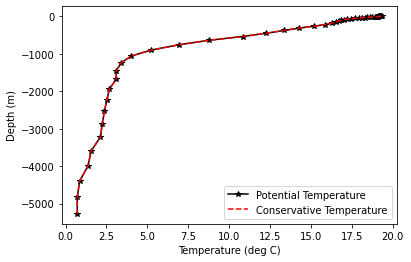

In [36]:
plt.plot(pt_sampling, -depth, '*-k', label='Potential Temperature')
plt.plot(CT_sampling, -depth, '--r', label='Conservative Temperature')
plt.legend()
plt.xlabel('Temperature (deg C)')
plt.ylabel('Depth (m)')

Text(0, 0.5, 'Depth (m)')

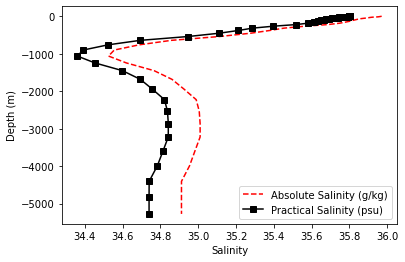

In [37]:
plt.plot(SA_sampling, -depth, '--r', label='Absolute Salinity (g/kg)')
plt.plot(PS_sampling, -depth, 's-k', label='Practical Salinity (psu)')
plt.legend()
plt.xlabel('Salinity')
plt.ylabel('Depth (m)')

In [38]:
rho_SACT = gsw.density.rho(SA_sampling, CT_sampling, pressure)

In [39]:
rho_SPPT = gsw.density.rho(PS_sampling, pt_sampling, pressure)

In [42]:
rho_SACT

<xarray.DataArray 'vosaline' (deptht: 50)>
array([1025.55689332, 1025.57152895, 1025.59023083, 1025.60457153,
       1025.61709138, 1025.62913556, 1025.64105483, 1025.65345827,
       1025.66718635, 1025.68273209, 1025.70104617, 1025.72615092,
       1025.76644493, 1025.81602056, 1025.86761528, 1025.92049313,
       1025.97906326, 1026.04939459, 1026.1347331 , 1026.23052206,
       1026.32983475, 1026.42861621, 1026.53235854, 1026.64663253,
       1026.78432669, 1026.95521282, 1027.15916055, 1027.42131738,
       1027.76704563, 1028.18033471, 1028.65745188, 1029.20358964,
       1029.84348321, 1030.55459154, 1031.33329891, 1032.21080321,
       1033.20765757, 1034.30933938, 1035.44941917, 1036.73068452,
       1038.09061603, 1039.52156155, 1041.04209828, 1042.64988824,
       1044.40258002, 1046.16671832, 1048.04834219, 1049.94930656,
       1051.86663863,           nan])
Coordinates:
    nav_lon       float32 6.25
    nav_lat       float32 -32.16
  * deptht        (deptht) float64 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
    x             int32 3521
    y             int32 1087
    time_counter  datetime64[ns] 2019-12-01T12:00:00
Attributes:
    units:               PSU
    valid_min:           0.0
    valid_max:           50.0
    long_name:           Salinity
    standard_name:       sea_water_salinity
    short_name:          vosaline
    online_operation:    N/A
    interval_operation:  86400
    interval_write:      86400
    associate:           time_counter deptht nav_lat nav_lon

In [45]:
depth

<xarray.DataArray 'deptht' (deptht: 50)>
array([4.940254e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00, 5.078224e+00,
       6.440614e+00, 7.929560e+00, 9.572997e+00, 1.140500e+01, 1.346714e+01,
       1.581007e+01, 1.849556e+01, 2.159882e+01, 2.521141e+01, 2.944473e+01,
       3.443415e+01, 4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02, 1.558507e+02,
       1.861256e+02, 2.224752e+02, 2.660403e+02, 3.181274e+02, 3.802130e+02,
       4.539377e+02, 5.410889e+02, 6.435668e+02, 7.633331e+02, 9.023393e+02,
       1.062440e+03, 1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03, 3.597032e+03,
       3.992484e+03, 4.405224e+03, 4.833291e+03, 5.274784e+03, 5.727917e+03])
Coordinates:
  * deptht        (deptht) float64 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
    time_counter  datetime64[ns] 2019-12-01T12:00:00
Attributes:
    units:          m
    positive:       down
    valid_min:      0.4940253794193268
    valid_max:      5727.91650390625
    long_name:      Vertical T levels
    standard_name:  depth
    axis:           Z

In [46]:
np.save('../notebooks/julia/density_profile.npy', rho_SACT)
np.save('../notebooks/julia/depth_profile.npy', depth)

In [44]:
np.load('../notebooks/julia/density_profile.npy')

array([1025.55689332, 1025.57152895, 1025.59023083, 1025.60457153,
       1025.61709138, 1025.62913556, 1025.64105483, 1025.65345827,
       1025.66718635, 1025.68273209, 1025.70104617, 1025.72615092,
       1025.76644493, 1025.81602056, 1025.86761528, 1025.92049313,
       1025.97906326, 1026.04939459, 1026.1347331 , 1026.23052206,
       1026.32983475, 1026.42861621, 1026.53235854, 1026.64663253,
       1026.78432669, 1026.95521282, 1027.15916055, 1027.42131738,
       1027.76704563, 1028.18033471, 1028.65745188, 1029.20358964,
       1029.84348321, 1030.55459154, 1031.33329891, 1032.21080321,
       1033.20765757, 1034.30933938, 1035.44941917, 1036.73068452,
       1038.09061603, 1039.52156155, 1041.04209828, 1042.64988824,
       1044.40258002, 1046.16671832, 1048.04834219, 1049.94930656,
       1051.86663863,           nan])

Text(0, 0.5, 'Depth (m)')

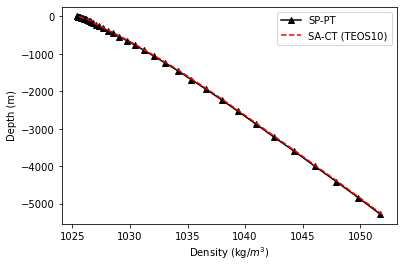

In [40]:
plt.plot(rho_SPPT, -depth, '^-k', label='SP-PT')
plt.plot(rho_SACT, -depth, '--r', label='SA-CT (TEOS10)')
plt.legend()
plt.xlabel(r'Density (kg/$m^3$)')
plt.ylabel('Depth (m)')

Text(0.5, 1.0, '$\\frac{\\rho_{TEOS10}}{\\rho_{SP-TP}}$')

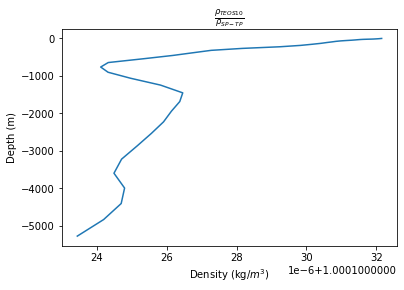

In [41]:
plt.plot(rho_SACT/rho_SPPT, -depth)
plt.xlabel(r'Density (kg/$m^3$)')
plt.ylabel('Depth (m)')
plt.title(r'$\frac{\rho_{TEOS10}}{\rho_{SP-TP}}$')
# plt.plot(rho_SACT, -depth)

## 1D-model for sinking particles

In [85]:
def beta(ρ_f, ρ_p):
    _β = 3*ρ_f/(2*ρ_p + ρ_f)
    
    return _β

def tau_p(a, β):
    ν = 1e-6
    _τ = a**2/(3*β*ν)
    
    return _τ

density_teos = interpolate.interp1d(depth, rho_SACT)
density_SP_PT = interpolate.interp1d(depth, rho_SPPT)

def sinking_velocity(state):
    a, ρ_p, depth = state
    
    # depth positive down
    g = 9.81
    seafloor = 5000
    
    if depth >= 1:
        ρ_f = density_SP_PT(depth)
    else:
        ρ_f = ρ_p
        
    β = beta(ρ_f, ρ_p)
    τ = tau_p(a, β)
    
    if depth < seafloor and depth > 0:
        v_s = (1 - β)*g*τ
    else:
        v_s = 0
    
    return np.array((0, 0, v_s))

def sinking_velocity_SP_PT(state):
    a, ρ_p, depth = state
    
    # depth positive down
    g = 9.81
    seafloor = 5000
    
    if depth >= 5:
        ρ_f = density_SP_PT(depth)
    else:
        ρ_f = ρ_p
        
    β = beta(ρ_f, ρ_p)
    τ = tau_p(a, β)
    
    if depth < seafloor and depth > 0:
        v_s = (1 - β)*g*τ
    else:
        v_s = 0
    
    return np.array((0, 0, v_s))


In [86]:
density_SP_PT(5200)

array(1051.41194589)

In [87]:
def euler(state, dt, derivatives):
    """
        state: numpy array giving the state of the pendulum at time t
        t: starting time
        dt: integration step
        derivatives: function that calculate the derivatives of the coordinates
        
        Function that performs an integration step using to runge-kutta algorithm
        
        Returns an np.array containing the new state (theta, omega)
    """
    
    #Calculate the ks
    k1 = dt * derivatives(state)
    
    #And consequently the new state of the system
    new_state = state + k1
    
    return new_state

In [88]:
def runge_kutta(state, dt, derivatives):
    """
        state: numpy array giving the state of the pendulum at time t
        t: starting time
        dt: integration step
        derivatives: function that calculate the derivatives of the coordinates
        
        Function that performs an integration step using to runge-kutta algorithm
        
        Returns an np.array containing the new state (theta, omega)
    """
    
    #Calculate the ks
    k1 = dt * derivatives(state)
    k2 = dt * derivatives(state + (0.5 * k1))
    k3 = dt * derivatives(state + (0.5 * k2))
    k4 = dt * derivatives(state + k3)
    
    #And consequently the new state of the system
    new_state = state + (k1 + 2*k2 + 2*k3 + k4) / 6.
    
    return new_state

In [89]:
def solver(f, sizes, densities, depths, dt, N_t, N, integrator):
    """
        solver(f, x0, y0, v0, u0, dt, N_t, N, b = 0.5)

    Function iterate the solution using runge_kutta_step and a RHS function f, for several points or initial 
    conditions given by N.

    f is a RHS function
    x0, y0, v0, u0 are arrays containig the initial condition x,y,v,u; with N dimensions.
    dt is the timestep, 
    N_t number of time steps.
    N number of initial conditions to iterate.

    """
    
    solution = np.zeros((3, N_t+1, N))
    solution[0,0, :] = sizes
    solution[1,0, :] = densities
    solution[2,0,: ] = depths
    
    for i in range(1, N_t + 1):
        for k in range(N):
            
            x_0_step = solution[:, i-1, k]
            solution[:, i, k] = integrator(x_0_step, dt, f)
         
    return solution

In [90]:
n_particles = 10
particles_sizes = np.linspace(1e-7, 1e-3, n_particles)
particles_densities = np.ones(n_particles)*ρ_PE #np.linspace(1030, 1100, n_particles)
initial_depths = np.ones(n_particles)*100


In [93]:
integration_time = 10
dt = 60*60
time_dim = np.linspace(0, integration_time*dt, integration_time+1)

solutions_sacp = solver(sinking_velocity, 
                        particles_sizes, 
                        particles_densities, 
                        initial_depths,
                        dt, 
                        integration_time, n_particles,
                        runge_kutta)

solutions_sppt = solver(sinking_velocity_SP_PT, 
                        particles_sizes, 
                        particles_densities, 
                        initial_depths, 
                        dt, 
                        integration_time, n_particles,
                        runge_kutta)

ValueError: A value in x_new is above the interpolation range.

In [58]:
solutions_sacp_euler = solver(sinking_velocity, 
                        particles_sizes, 
                        particles_densities, 
                        initial_depths,
                        dt, 
                        integration_time, n_particles,
                        euler)

solutions_sppt_euler = solver(sinking_velocity_SP_PT, 
                        particles_sizes, 
                        particles_densities, 
                        initial_depths, 
                        dt, 
                        integration_time, n_particles,
                        euler)

In [59]:
vs_sacp = np.diff(solutions_sacp[2], axis=0)/dt
vs_sppt = np.diff(solutions_sppt[2], axis=0)/dt
vs_sacp_euler = np.diff(solutions_sacp_euler[2], axis=0)/dt
vs_sppt_euler = np.diff(solutions_sppt_euler[2], axis=0)/dt

In [60]:
vs_sacp.shape

(10, 10)

Text(0.5, 1.0, 'SA - CT')

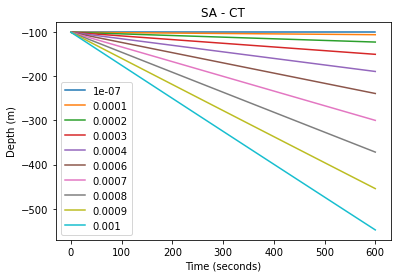

In [61]:
for i in range(n_particles):
    plt.plot(time_dim, -solutions_sacp[2,:,i], label=f'{particles_sizes[i]:.1}');
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Depth (m)')
plt.title('SA - CT')

Text(0.5, 1.0, 'SP - PT')

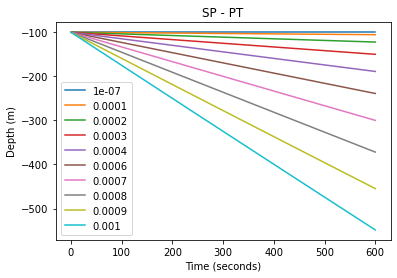

In [62]:
for i in range(n_particles):
    plt.plot(time_dim, -solutions_sppt[2,:,i], label=f'{particles_sizes[i]:.1}');
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Depth (m)')
plt.title('SP - PT')

Text(0.5, 1.0, 'Depth Difference (SACT - CPPT)')

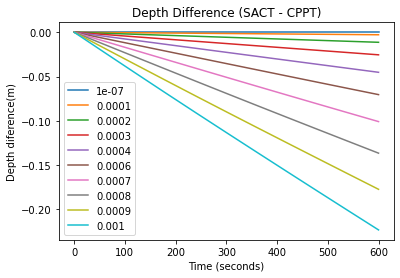

In [63]:
for i in range(n_particles):
    plt.plot(time_dim, solutions_sacp[2,:,i] - solutions_sppt[2,:,i], label=f'{particles_sizes[i]:.1}');
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Depth diference(m)')
plt.title('Depth Difference (SACT - CPPT)')

# Euler vs RK4

In [64]:
solutions_sacp.shape

(3, 11, 10)

Text(0.5, 1.0, 'Depth Difference (RK4 - Euler)')

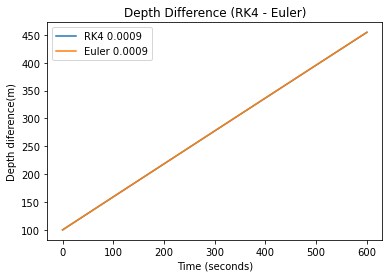

In [65]:
for i in range(8, 9):
    plt.plot(time_dim, solutions_sacp[2,:,i], label=f'RK4 {particles_sizes[i]:.1}');
    plt.plot(time_dim, solutions_sacp_euler[2,:,i], label=f'Euler {particles_sizes[i]:.1}');
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Depth diference(m)')
plt.title('Depth Difference (RK4 - Euler)')

In [42]:
vs_sppt.shape

(10000, 10)

Text(0, 0.5, 'Sinking velocity (m/s)')

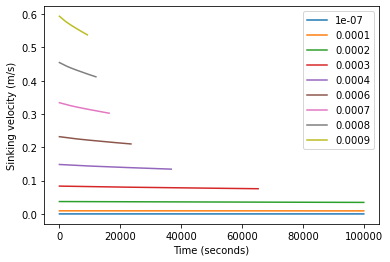

In [43]:
for i in range(9):
    plt.plot(time_dim[1:], vs_sppt[:,i], label=f'{particles_sizes[i]:.1}');
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Sinking velocity (m/s)')


Text(0.5, 1.0, 'SA - CT')

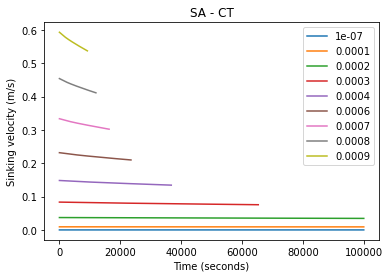

In [44]:
for i in range(9):
    plt.plot(time_dim[1:], vs_sacp[:,i], label=f'{particles_sizes[i]:.1}');
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Sinking velocity (m/s)')
plt.title('SA - CT')

Text(0.5, 1.0, 'vs_sacp - vs_sppt')

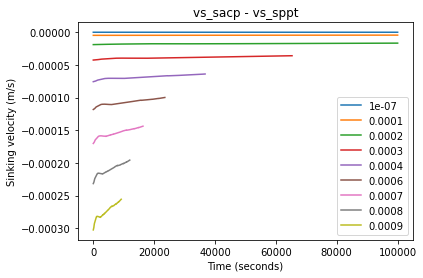

In [45]:
for i in range(9):
    plt.plot(time_dim[1:], vs_sacp[:,i] - vs_sppt[:,i], label=f'{particles_sizes[i]:.1}');
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Sinking velocity (m/s)')
plt.title('vs_sacp - vs_sppt')

Fractions



In [46]:
plt.plot(np.diff(solutions_100m_sppt[2],axis=1));

NameError: name 'solutions_100m_sppt' is not defined

In [ ]:
d0 = (0.001, 900, 10)

In [ ]:
d0 = runge_kutta(d0, 1, sinking_velocity)
d0

In [ ]:
state_0 = [0.001, 1030, 10]

time_range = np.linspace(0, 100000, 10001)
dt = time_range[1] - time_range[0]
sol = np.array([state_0])

for i, t in enumerate(time_range):

    _state = runge_kutta(sol[i], dt, sinking_velocity)
    sol = np.vstack((sol, _state))
    

In [ ]:
sol.shape

In [ ]:
sol[:, 2].shape

In [ ]:
plt.plot(time_range, sol[1:, 2])